## Use the active subspace method on a reduced order cardiovascular model


The cardiovascular model can be expressed as a system of differential equations:
\begin{align*}
\frac{dV_{lv}}{dt} &= Q_{MV} - Q_{AV} \\
\frac{dV_{ao}}{dt} &= Q_{AV} - Q_{art\_sys}
\end{align*}

Where:
\begin{align*} 
Q_{MV} &= \max\left(\frac{P_{LA} - p_{lv}}{R_{MV}}, 0\right) \\ \\
 Q_{AV} &= \max\left(\frac{p_{lv} - p_{ao}}{R_{AV}}, 0\right) \\ \\
Q_{art\_sys} &= \frac{p_{ao} - P_{SysCap}}{R_{art}} \\ \\
p_{lv} &= E(t)(Vlv-V_d) \\ \\
p_{ao} &= \frac{V_{ao}}{C_{ao}}\\ \\
\end{align*}


The linear elastance function, which represents the muscle contraction in the heart, is expressed as:
$$E(t) = 
    \begin{cases} 
      \frac{(E_{max} - E_{min})}{2}\left(1 - \cos\left(\frac{\pi t}{ T_{peak}}\right)\right) + E_{min}, & \text{if } t \leq T_{peak} \\ \\
        \frac{(E_{max} - E_{min})}{2}\left(1 + \cos\left(\frac{\pi (t - T_{peak})}{(T_{relax} - T_{peak})}\right)\right) + E_{min}, & \text{if } t \leq T_{relax} \\ \\
      E_{min}, & \text{otherwise}
    \end{cases}$$


The full parameter vector is then
$$\theta = \left\{P_{LA},P_{sys,cap},R_{mv},R_{av},R_{art},C_{ao},E_{max},E_{min},V_{lv,d},T_{peak},T_{relax}\right\} $$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
## Active subspace methods

import numpy as np
from scipy.linalg import svd
from scipy.stats import qmc


In [ ]:


def ActiveSubspace_SVD_Algorithm(f, UB, LB, M, Ny, CS_flag, param_ids, param_base):
    """
    Implements active subspace methods using Singular Value Decomposition (SVD).

    Parameters:
        f : function
            Quantity of interest function.
        UB : numpy array
            Upper bounds for parameters.
        LB : numpy array
            Lower bounds for parameters.
        M : int
            Number of samples.
        Ny : int
            Output dimensions.
        CS_flag : int
            0 for finite differences, 1 for complex step method.
        param_ids : list
            Indices of active parameters.
        param_base : numpy array
            Base parameter values.
        parallel_flag : int
            0 for sequential execution, 1 for parallel execution.

    Returns:
        G_f : numpy array
            Scaled gradient matrix.
        Lambda : numpy array
            Singular values of G_f.
        W : numpy array
            Rotation matrix.
        act_scores : numpy array
            Activity scores indicating parameter sensitivity.
    """

    ids_fix = list(range(len(UB)))
    for idx in param_ids:
        ids_fix.remove(idx)

    num_param = len(param_ids)
    UB = UB[param_ids]
    LB = LB[param_ids]

    # Latin hypercube sampling
    lhs = qmc.LatinHypercube(num_param).random(M)
    X = LB + (UB - LB) * lhs

    h = 1e-6
    par_LHS = np.zeros((len(param_ids) + len(ids_fix), M))
    for i in range(M):
        par_LHS[ids_fix,i] =  param_base[ids_fix]
        par_LHS[param_ids, i] = X[i,:]

    G_f = np.zeros((num_param, M))

    # Compute gradients
    I_h = np.eye(len(param_ids) + len(ids_fix)) * h
    n_par = np.size(param_ids)
    if CS_flag == 0:  # Forward finite difference method
        for i in range(M):
            grad_f = np.zeros((num_param, Ny))
            # print(par_LHS[:, i] + I_h[1, :])
            fbase = f(par_LHS[:,i])
            for j in range(n_par):
                # Centered difference
                # par_plus = par_LHS[:, i] + I_h[param_ids[j], :]
                # par_minus = par_LHS[:, i] - I_h[param_ids[j], :]
                # fstepP = f(par_plus)
                # fstepM = f(par_minus)
                # grad_f[j, :] = 0.5 * (fstepP - fstepM) / h
                # Forward difference
                par_plus = par_LHS[:, i] + I_h[param_ids[j], :]
                fstepP = f(par_plus)
                grad_f[j, :] = (fstepP - fbase) / h
                print(param_ids[j],grad_f[j, :], par_plus)
            if int(i / M * 100) % 10 == 0:
                print(f"{int(i / M * 100)} percent complete.")

            G_f[:, i] = grad_f.ravel()
    else:  # Complex step method
        I_h = np.eye(len(param_ids) + len(ids_fix)) * h * 1j
        for i in range(M):
            grad_f = np.zeros((num_param, Ny))
            for j in range(n_par):
                fstepP = f(par_LHS[:, i] + I_h[param_ids[j], :])
                grad_f[j, :] = np.imag(fstepP) / h
                print(np.imag(fstepP) / h)
            if int(i / M * 100) % 10 == 0:
                print(f"{int(i / M * 100)} percent complete.")
            G_f[:, i] = grad_f.ravel()

    G_f /= np.sqrt(M)

    # Singular value decomposition
    W, Lambda, _ = svd(G_f, full_matrices=False)
    act_scores = np.sum((Lambda ** 2) * (W.T ** 2), axis=1)

    return G_f, Lambda, W, act_scores


In [300]:
## Cardiovascular Model snippets

def LinearElastance(V, t, pars):
    # Unpack parameters
    Emax, Emin, Vd, T_peak, T_relax, T = pars
    
    # Ensure t is within cardiac cycle length
    t = np.mod(t, np.real(T))
    
    # Compute elastance E at each time point
    E = np.zeros_like(t)
    
    E[t <= T_peak] = (Emax - Emin) * (1 - np.cos(np.pi * t[t <= T_peak] / T_peak)) / 2 + Emin
    mask_relax = (t > T_peak) & (t <= T_relax)
    E[mask_relax] = (Emax - Emin) * (1 + np.cos(np.pi * (t[mask_relax] - T_peak) / (T_relax - T_peak))) / 2 + Emin
    E[t > T_relax] = Emin
    
    # Compute pressure as elastance times volume
    p = E * (V - Vd)
    
    return p

def cardiovascular_model(t, y, param):
    # Extract variables
    Vlv, Vao = y

    # Unpack parameters
    P_LeftAtr, P_SysCap, Rmv, Rav, Rsysart, Cao, Emax, Emin, Vlv_d, T_peak, T_relax, T = param

    # Compute pressures
    plv = LinearElastance(Vlv, t, param[6:12])
    pao = Vao / Cao

    # Compute flows through valves and systemic arteries
    qmv = np.maximum((P_LeftAtr - plv) / Rmv, 0)
    qav = np.maximum((plv - pao) / Rav, 0)
    qcap = (pao - P_SysCap) / Rsysart

    # Update differential equations
    dVlv = qmv - qav
    dVsa = qav - qcap
    
    return np.array([dVlv, dVsa])

def call_CV_model(IC, param, tspace):
    # Define solver options
    solver_options = {'rtol': 1e-8, 'atol': 1e-8}
    param = np.exp(param)
    T = np.real(param[-1])  # Last parameter
    
    # Solve ODE system
    sol = solve_ivp(lambda t, y: cardiovascular_model(t, y, param), 
                    [tspace[0], tspace[-1]], IC, method='RK45', **solver_options)
    
    # Extract last two cycles for plotting
    tplot = np.linspace(tspace[-1] - T, tspace[-1], 50)
    

    yout = np.zeros((2,50))
    yout[0,:] = np.interp(tplot, sol.t, sol.y.T[:,0])
    yout[1,:] = np.interp(tplot, sol.t, sol.y.T[:,1])

    tplot -= tplot[0]  # Shift for consistency
    
    # Extract solutions
    Vlv = yout[0, :]
    Vao = yout[1, :]
    
    # Unpack parameters
    P_LA, P_SysCap, Rmv, Rav, Rart, Cao = param[:6]
    
    # Compute pressures and flows
    plv = LinearElastance(Vlv, tplot, param[6:12])
    pao = Vao / Cao
    
    qmv = np.maximum((P_LA - plv) / Rmv, 0)
    qav = np.maximum((plv - pao) / Rav, 0)
    qart = (pao - P_SysCap) / Rart
    
    output = {
        "Vlv": Vlv,
        "Vao": Vao,
        "plv": plv,
        "pao": pao,
        "qmv": qmv,
        "qav": qav,
        "qart": qart
    }
    return output

In [301]:
def get_CV_parameters():
    """
    Defines initial conditions and parameters for the cardiovascular model.
    
    Returns:
        IC : numpy array
            Initial conditions [Vlv_init, Vao_init]
        param : numpy array
            Model parameters
    """
    
    # Define system parameters
    P_LA     = 5      # Left atrial pressure (mmHg)
    P_SysCap = 20     # Systemic capillary pressure (mmHg)
    Rmv      = 5e-3   # Resistance in the mitral valve (mmHg·s/μL)
    Rav      = 1e-2   # Resistance in the aortic valve (mmHg·s/μL)
    Rart     = 1.2    # Resistance of systemic arteries/arterioles (mmHg·s/mL)
    Cao      = 1.1    # Aortic compliance (mL·s/mmHg)
    Emax     = 1.3    # End-systolic elastance (mmHg/mL)
    Emin     = 0.03   # Nonlinear elastance term (1/mL)
    Vlv_d    = 5      # Volume not ejected in the heart (mL)
    T_peak   = 0.25   # Peak elastance (s)
    T_relax  = 0.55   # End of systole (s)
    T        = 1.0    # Total cycle length (s)
    
    # Stack parameters into an array
    param = np.array([P_LA, P_SysCap, Rmv, Rav, Rart, Cao, Emax, Emin, Vlv_d, T_peak, T_relax, T])

    # Define initial conditions (volumes in microliters)
    Vlv_init = 200  # Left ventricular volume
    Vao_init = 380  # Aortic volume
    IC = np.array([Vlv_init, Vao_init])  # Initial conditions

    return IC, param


In [ ]:

# Define parameter names
param_names = ['P LA', 'P SysCap', 'Rmv', 'Rav', 'Rart', 'Cao', 'Emax', 'Emin', 'Vlvd', 'T peak', 'T relax', 'T']

# Get initial conditions and parameters
IC, param = get_CV_parameters()
T = param[11]  # Zero-based index for Python
param = np.log(param)
# Define time space
tstart = 0
tend = 20 * T  # 30 cycles
dt = 1e-3
tspace = np.arange(tstart, tend, dt)
param_base = param.copy()

## Generate pseudo data
output = call_CV_model(IC, param, tspace)
pao_data = output['pao']+ np.random.normal(0, 1, size=50)
qav_data = output['qav']+ np.random.normal(0, 10, size=50)
qmv_data = output['qav']+ np.random.normal(0, 10, size=50)

data = {'pao': pao_data, 'qav': qav_data, 'qmv': qmv_data}


outflag=4
# Define active subspace function
def act_subspace_f(q):
    output = call_CV_model(IC, q, tspace)

    if outflag == 1:  # systolic LV pressure
        return np.max(output['plv'])
    elif outflag == 2:  # systolic Ao pressure
        return np.max(output['pao'])
    elif outflag == 3:  # diastolic Ao pressure
        return np.min(output['pao'])
    elif outflag == 4:  # residual function
        res1 = (data['pao'] - output['pao']) / np.max(data['pao'])
        res2 = (data['qav'] - output['qav']) / np.max(data['qav'])
        res3 = (data['qmv'] - output['qmv']) / np.max(data['qmv'])
        return np.sum(np.square(np.array([res1, res2, res3])))
    

# Set up active subspace parameters
param_ids = [0,1,2,3,4,5,6,7,8,9,10]  # Adjusted for zero-based indexing
UB = param * 1.2
LB = param * 0.8

M = 100
Ny = 1
CS_flag = 0  # Use complex step; otherwise, centered finite difference
parallel_flag = 1

# Run active subspace algorithm
G_f, Lambda, W, act_scores = ActiveSubspace_SVD_Algorithm(act_subspace_f, UB, LB, M, Ny, CS_flag, param_ids, param_base,parallel_flag)


0 [308.07927922] [ 1.70731977  2.96150094 -4.75413215 -4.57638754  0.18215924  0.09287333
  0.2746316  -4.05692966  1.41779389 -1.49887304 -0.66686019  0.        ]
1 [471.42926053] [ 1.70731877  2.96150194 -4.75413215 -4.57638754  0.18215924  0.09287333
  0.2746316  -4.05692966  1.41779389 -1.49887304 -0.66686019  0.        ]
2 [-239.23115572] [ 1.70731877  2.96150094 -4.75413115 -4.57638754  0.18215924  0.09287333
  0.2746316  -4.05692966  1.41779389 -1.49887304 -0.66686019  0.        ]
3 [517.03944334] [ 1.70731877  2.96150094 -4.75413215 -4.57638654  0.18215924  0.09287333
  0.2746316  -4.05692966  1.41779389 -1.49887304 -0.66686019  0.        ]
4 [-1115.88169869] [ 1.70731877  2.96150094 -4.75413215 -4.57638754  0.18216024  0.09287333
  0.2746316  -4.05692966  1.41779389 -1.49887304 -0.66686019  0.        ]
5 [199.70943328] [ 1.70731877  2.96150094 -4.75413215 -4.57638754  0.18215924  0.09287433
  0.2746316  -4.05692966  1.41779389 -1.49887304 -0.66686019  0.        ]
6 [-578.76423

KeyboardInterrupt: 

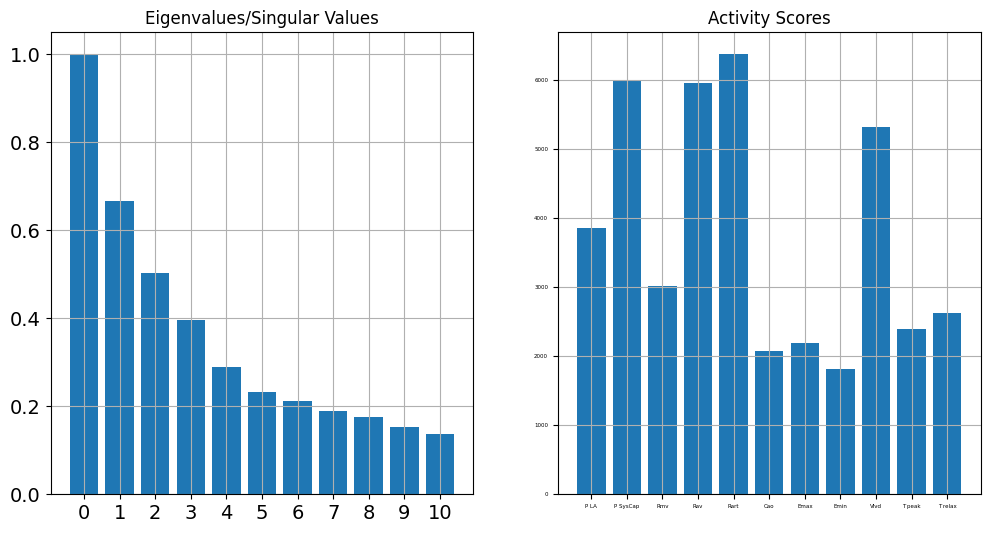

In [293]:
# Plot results
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].bar(range(len(param_ids)), Lambda / np.max(Lambda))
axs[0].set_xticks(range(len(param_ids)))
axs[0].set_title('Eigenvalues/Singular Values')
axs[0].grid(True)
axs[0].tick_params(axis='both', labelsize=14)

axs[1].bar(range(len(param_ids)), act_scores)
axs[1].set_xticks(range(len(param_ids)))
axs[1].set_xticklabels([param_names[i] for i in param_ids])
axs[1].set_title('Activity Scores')
axs[1].grid(True)
axs[1].tick_params(axis='both', labelsize=4)

plt.show()

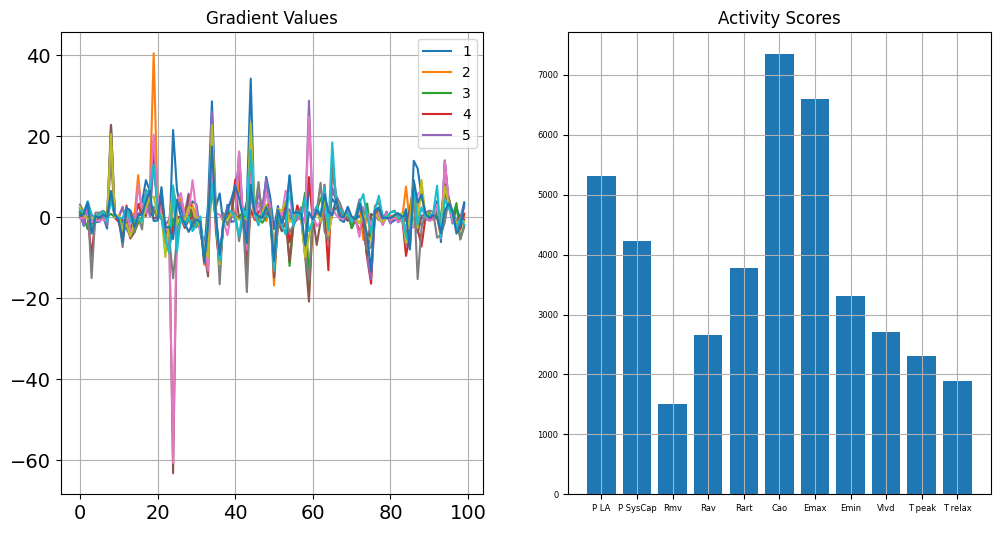

In [304]:
temp = np.sum((Lambda ** 2) * (W ** 2), axis=1)
# Plot results
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].plot(G_f.T)
axs[0].set_title('Gradient Values')
axs[0].grid(True)
axs[0].tick_params(axis='both', labelsize=14)
axs[0].legend(('1','2','3','4','5'))

axs[1].bar(range(len(param_ids)), temp)
axs[1].set_xticks(range(len(param_ids)))
axs[1].set_xticklabels([param_names[i] for i in param_ids])
axs[1].set_title('Activity Scores')
axs[1].grid(True)
axs[1].tick_params(axis='both', labelsize=6)

plt.show()

In [205]:
param

array([5.0e+00, 2.0e+01, 5.0e-03, 1.0e-02, 1.2e+00, 1.1e+00, 1.3e+00,
       3.0e-02, 5.0e+00, 2.5e-01, 5.5e-01, 1.0e+00])